Step 1: Load the dataset ,here we are uploading News_Category_Dataset_v3.json

In [ ]:
import json

data = []
with open("/content/News_Category_Dataset_v3.json", 'r') as f:
    for line in f:
        data.append(json.loads(line))


Let's have a look at the dataset

In [ ]:
data[:2]

[{'link': 'https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9',
  'headline': 'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters',
  'category': 'U.S. NEWS',
  'short_description': 'Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.',
  'authors': 'Carla K. Johnson, AP',
  'date': '2022-09-23'},
 {'link': 'https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe',
  'headline': 'American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video',
  'category': 'U.S. NEWS',
  'short_description': "He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",
  'authors': 'Mary Papenfuss',
  'date': '2022-09-23'}]

In [ ]:
print(len(data))

209527


In [ ]:
import pandas as pd

In [ ]:
# we only need the headlines text from the dataset
# Assuming data is a list of dictionaries where each dictionary represents a data entry
data_text = [entry["headline"] for entry in data]

# Convert data_text to a DataFrame with an "index" column
data_text_df = pd.DataFrame(data_text, columns=["headline"])
data_text_df["index"] = data_text_df.index

# Optional: Rename the DataFrame to 'documents' as in your code
documents = data_text_df


since our task is to classify the news_article based on news headings only so I am taking only headline

In [ ]:
documents[:5]

,headline,index
0,Over 4 Million Americans Roll Up Sleeves For O...,0
1,"American Airlines Flyer Charged, Banned For Li...",1
2,23 Of The Funniest Tweets About Cats And Dogs ...,2
3,The Funniest Tweets From Parents This Week (Se...,3
4,Woman Who Called Cops On Black Bird-Watcher Lo...,4


In [ ]:
print(len(documents))

209527


Data Preprocessing:

*   **Tokenization**:split the text into sentences and sentences into words.Lowercase the words and remove punctuation
*   remove all stopwords


*   words are Lemmatized -words in third person are changed to first person and past and future tense are changed to present tense
*   words are stemmed-removing the prefix and suffix







In [ ]:
#loading Gensim and nltk libraries
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer,SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

In [ ]:
import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Lemmatizer Example**



In [ ]:
#Lemmatizer
print(WordNetLemmatizer().lemmatize("went",pos="v"))

go


**Stemmer Example**

In [ ]:
#stemmer
stemmer=SnowballStemmer("english")
original_words=["dies","sized","stating"]
singles=[stemmer.stem(plural) for plural in original_words]
pd.DataFrame(data={"original word":original_words,"stemmed":singles})

,original word,stemmed
0,dies,die
1,sized,size
2,stating,state


In [ ]:
#function to perform the pre-processing steps
def lemmatize_stemming(text):
  return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos="v"))
  #tokenize and lemmatize
def preprocess(text):
  result=[]
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >3:
      result.append(lemmatize_stemming(token))
  return result

In [ ]:
# preview document after preprocessing
document_num=400
doc_sample=documents[documents["index"]==document_num].values[0][0]
doc_sample

'At Least 15 Killed In South Africa Bar Shooting'

In [ ]:
print("Original document")
words=[]
for word in doc_sample.split(" "):
  words.append(word)
print(words)
print("\n\n Tokenized and lemmatized document")
print(preprocess(doc_sample))

Original document
['At', 'Least', '15', 'Killed', 'In', 'South', 'Africa', 'Bar', 'Shooting']


 Tokenized and lemmatized document
['kill', 'south', 'africa', 'shoot']


In [ ]:
documents

,headline,index
0,Over 4 Million Americans Roll Up Sleeves For O...,0
1,"American Airlines Flyer Charged, Banned For Li...",1
2,23 Of The Funniest Tweets About Cats And Dogs ...,2
3,The Funniest Tweets From Parents This Week (Se...,3
4,Woman Who Called Cops On Black Bird-Watcher Lo...,4
...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,209522
209523,Maria Sharapova Stunned By Victoria Azarenka I...,209523
209524,"Giants Over Patriots, Jets Over Colts Among M...",209524
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,209525


now preprocess the news headlines we have.to do that we are using map function from pandas to apply preprocess() to the headline column

In [ ]:
preprocess_docs=documents["headline"].map(lambda x: preprocess(x))

In [ ]:
preprocess_docs[:10]

0    [million, american, roll, sleev, omicron, targ...
1    [american, airlin, flyer, charg, ban, life, pu...
2              [funniest, tweet, cat, dog, week, sept]
3                [funniest, tweet, parent, week, sept]
4    [woman, call, cop, black, bird, watcher, lose,...
5    [cleaner, dead, belk, bathroom, day, bodi, polic]
6        [report, get, ador, surpris, boyfriend, live]
7    [puerto, rican, desper, water, hurrican, fiona...
8        [documentari, captur, complex, child, immigr]
9             [biden, russian, affront, bodi, charter]
Name: headline, dtype: object

Now let's create a dictionary from 'processed_docs' containing the number of times a word appears in the training set. To do that, let's pass processed_docs to gensim.corpora.Dictionary() and call it 'dictionary'.

In [ ]:
#bag of words om the dataset
dictionary=gensim.corpora.Dictionary(preprocess_docs)

In [ ]:
#check dictionary created
count=0
for k,v in dictionary.iteritems():
  print(k,v)
  count+=1
  if count > 10:
    break

0 american
1 booster
2 covid
3 million
4 omicron
5 roll
6 sleev
7 target
8 airlin
9 attend
10 ban


In [ ]:
print(dictionary)

Dictionary<36647 unique tokens: ['american', 'booster', 'covid', 'million', 'omicron']...>


In [ ]:
from collections import Counter
count=Counter()
for doc in preprocess_docs:
  for word in doc:
    count[word]+=1
print(count)

Counter({'trump': 14425, 'photo': 12446, 'video': 6283, 'year': 4991, 'donald': 4850, 'say': 4821, 'best': 3902, 'women': 3515, 'time': 3465, 'world': 3463, 'week': 3315, 'like': 3200, 'love': 3158, 'life': 3075, 'peopl': 3065, 'look': 3022, 'thing': 2996, 'want': 2966, 'need': 2905, 'help': 2797, 'know': 2777, 'kid': 2735, 'report': 2713, 'live': 2696, 'american': 2663, 'obama': 2662, 'hous': 2494, 'get': 2463, 'chang': 2463, 'parent': 2451, 'home': 2411, 'health': 2404, 'star': 2360, 'way': 2339, 'wed': 2322, 'black': 2314, 'right': 2265, 'watch': 2223, 'america': 2219, 'state': 2200, 'clinton': 2199, 'food': 2155, 'white': 2103, 'make': 2098, 'school': 2066, 'work': 2023, 'talk': 2022, 'famili': 2009, 'go': 1982, 'shoot': 1964, 'presid': 1918, 'kill': 1913, 'babi': 1908, 'celebr': 1896, 'plan': 1876, 'studi': 1825, 'come': 1798, 'travel': 1785, 'divorc': 1777, 'take': 1770, 'woman': 1751, 'polic': 1746, 'think': 1734, 'good': 1731, 'lose': 1692, 'girl': 1690, 'hillari': 1669, 'repub

In [ ]:
print(count["photo"])

12446


In [ ]:
len(count)

36647

In [ ]:
#filter_extreme
dictionary.filter_extremes(no_below=15,no_above=0.1,keep_n=100000)

filter out tokens that appear in

*  less than no_below documents(absolute number)
*  or more than no_above documents (fraction of total corpus size,not absolute number)


*   after this keep only the first keep_n most frequent tokens





In [ ]:
len(dictionary)

7480

In [ ]:
#creating bag of words model for each documents ,for each document we created a dictionary of words and how many  times those words appear ,save this tp bow_corpus
bow_corpus=[dictionary.doc2bow(doc) for doc in preprocess_docs]

In [ ]:
bow_corpus[document_num]

[(433, 1), (464, 1), (476, 1), (1414, 1)]

TF-IDF on our document:

Term Frequency (TF): This measures how frequently a term appears in a document. It's calculated by dividing the number of times a term appears in a document by the total number of terms in that document.

Inverse Document Frequency (IDF): This measures how unique a term is across all documents. It's calculated by taking the logarithm of the total number of documents divided by the number of documents containing the term.

TF-IDF Score: The TF-IDF score is the product of TF and IDF. It reflects the importance of a term in a document relative to its importance in the entire corpus of documents.

In [ ]:
# create TF-IDF model object using models.TfIDModel on 'Bow_corpus" and save it to tdidf

from gensim import corpora,models
tfidf=models.TfidfModel(bow_corpus)

In [ ]:
corpus_tfidf=tfidf[bow_corpus]

In [ ]:
# preview TF-IDF
from pprint import pprint
for doc in corpus_tfidf:
  pprint(doc)
  break

[(0, 0.2756574126836034),
 (1, 0.577418735823452),
 (2, 0.41253789976930527),
 (3, 0.3223998219431091),
 (4, 0.40579281807324596),
 (5, 0.38961983935341893)]


Running LDA using Bag of words:
We're aiming to extract 10 latent topics from our document corpus using LDA, and we'll leverage all CPU cores for faster model training. Here's a breakdown of some parameters we'll be adjusting:

**num_topics:** This parameter specifies the number of latent topics we want to extract from the training corpus.

**id2word: **It's a mapping from word IDs (integers) to words (strings). It helps determine the vocabulary size and aids in debugging and topic printing.

**workers:** This parameter determines the number of extra processes used for parallelization. By default, it utilizes all available CPU cores.

**alpha and eta:** These are hyperparameters affecting the sparsity of the document-topic (theta) and topic-word (lambda) distributions. For now, we'll stick with the default values (1/num_topics).

**Alpha:** Controls the per-document topic distribution.

High alpha: Each document has a mixture of all topics, making documents appear similar to each other.

Low alpha: Each document has a mixture of very few topics.

**Eta:** Governs the per-topic word distribution.

High eta: Each topic comprises a mixture of most words, resulting in topics appearing similar to each other.

Low eta: Each topic consists of a mixture of few words.

In [ ]:
pip install tqdm


In [ ]:
from tqdm import tqdm

# Define the number of passes
num_passes = 50

# Train the LDA model with tqdm progress bar
with tqdm(total=num_passes, desc="Training LDA Model") as pbar:
    for i in range(num_passes):
        lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=1, workers=2)
        pbar.update(1)  # Update the progress bar



Training LDA Model: 100%|██████████| 50/50 [34:51<00:00, 41.84s/it]


NameError: name 'logging' is not defined

In [ ]:
from gensim.models import CoherenceModel

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocess_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.2906932833205403


In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.024*"video" + 0.019*"design" + 0.013*"game" + 0.011*"mind" + 0.011*"evolut" + 0.011*"network" + 0.009*"father" + 0.007*"season" + 0.007*"green" + 0.007*"teen"


Topic: 1 
Words: 0.036*"photo" + 0.020*"poll" + 0.020*"america" + 0.016*"guid" + 0.011*"weekend" + 0.010*"drink" + 0.008*"roundup" + 0.008*"dinner" + 0.008*"video" + 0.008*"convers"


Topic: 2 
Words: 0.033*"tip" + 0.018*"stress" + 0.017*"free" + 0.013*"craft" + 0.013*"children" + 0.013*"right" + 0.008*"space" + 0.008*"fight" + 0.007*"obes" + 0.007*"research"


Topic: 3 
Words: 0.110*"photo" + 0.021*"love" + 0.021*"video" + 0.020*"style" + 0.013*"best" + 0.013*"babi" + 0.012*"beauti" + 0.011*"dress" + 0.011*"wed" + 0.009*"week"


Topic: 4 
Words: 0.034*"way" + 0.033*"look" + 0.019*"summer" + 0.016*"recip" + 0.014*"parent" + 0.014*"learn" + 0.013*"kid" + 0.011*"video" + 0.010*"like" + 0.010*"lesson"


Topic: 5 
Words: 0.021*"hous" + 0.019*"sleep" + 0.016*"night" + 0.015*"friend" + 0.011*"wall" + 0.010*"room" +

Classification of the topics
Using the words in each topic and their corresponding weights, what categories were you able to infer?




*   0: social, world news
*   1: Urgent issue / catastrophe

*   2: Accidents, wars, conflicts
*   3: Economy


*   4: Politics
*   5: Diplomacy


*   6: Agriculture
*   7: Sports



*   8: Justice
*   9: Claims, disputes















In [ ]:
document_num = 4310
# Our test document is document number 4310

# TODO
# Our test document is document number 4310
for index, score in sorted(lda_model[bow_corpus[document_num]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.5640257596969604	 
Topic: 0.037*"health" + 0.021*"cancer" + 0.017*"studi" + 0.016*"care" + 0.014*"risk" + 0.012*"propos" + 0.009*"link" + 0.008*"organ" + 0.007*"patient" + 0.007*"tast"

Score: 0.3359050452709198	 
Topic: 0.110*"photo" + 0.021*"love" + 0.021*"video" + 0.020*"style" + 0.013*"best" + 0.013*"babi" + 0.012*"beauti" + 0.011*"dress" + 0.011*"wed" + 0.009*"week"

Score: 0.012509817257523537	 
Topic: 0.033*"tip" + 0.018*"stress" + 0.017*"free" + 0.013*"craft" + 0.013*"children" + 0.013*"right" + 0.008*"space" + 0.008*"fight" + 0.007*"obes" + 0.007*"research"

Score: 0.012509310618042946	 
Topic: 0.021*"hous" + 0.019*"sleep" + 0.016*"night" + 0.015*"friend" + 0.011*"wall" + 0.010*"room" + 0.010*"white" + 0.008*"product" + 0.008*"street" + 0.008*"paul"

Score: 0.012508814223110676	 
Topic: 0.041*"divorc" + 0.023*"studi" + 0.018*"week" + 0.017*"food" + 0.016*"find" + 0.014*"healthi" + 0.012*"citi" + 0.011*"home" + 0.011*"marriag" + 0.010*"women"

Score: 0.012508531101047

In [ ]:
'''
Check which topic our test document belongs to using the LDA TF-IDF model.
'''
# Our test document is document number 4310
for index, score in sorted(lda_model[bow_corpus[document_num]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.564028263092041	 
Topic: 0.037*"health" + 0.021*"cancer" + 0.017*"studi" + 0.016*"care" + 0.014*"risk" + 0.012*"propos" + 0.009*"link" + 0.008*"organ" + 0.007*"patient" + 0.007*"tast"

Score: 0.33590254187583923	 
Topic: 0.110*"photo" + 0.021*"love" + 0.021*"video" + 0.020*"style" + 0.013*"best" + 0.013*"babi" + 0.012*"beauti" + 0.011*"dress" + 0.011*"wed" + 0.009*"week"

Score: 0.012509818188846111	 
Topic: 0.033*"tip" + 0.018*"stress" + 0.017*"free" + 0.013*"craft" + 0.013*"children" + 0.013*"right" + 0.008*"space" + 0.008*"fight" + 0.007*"obes" + 0.007*"research"

Score: 0.01250931154936552	 
Topic: 0.021*"hous" + 0.019*"sleep" + 0.016*"night" + 0.015*"friend" + 0.011*"wall" + 0.010*"room" + 0.010*"white" + 0.008*"product" + 0.008*"street" + 0.008*"paul"

Score: 0.01250881515443325	 
Topic: 0.041*"divorc" + 0.023*"studi" + 0.018*"week" + 0.017*"food" + 0.016*"find" + 0.014*"healthi" + 0.012*"citi" + 0.011*"home" + 0.011*"marriag" + 0.010*"women"

Score: 0.01250853203237056

In [ ]:
#testing on unseen data
unseen_document = "My favorite sports activities are running and swimming."

# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
threshold = 0.1
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    if score < threshold: break
    print("Score: {}\n Topic: {}".format(score, lda_model.print_topic(index, 5)))
    print()

Score: 0.39234164357185364
 Topic: 0.110*"photo" + 0.021*"love" + 0.021*"video" + 0.020*"style" + 0.013*"best"

Score: 0.2936677038669586
 Topic: 0.052*"photo" + 0.033*"video" + 0.023*"life" + 0.019*"fashion" + 0.013*"best"

Score: 0.19729594886302948
 Topic: 0.036*"photo" + 0.020*"poll" + 0.020*"america" + 0.016*"guid" + 0.011*"weekend"



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

In [ ]:
def word_cloud(topic, model):
    plt.figure(figsize = (8,6))
    topic_words = [model.print_topic(topic, 75)]
    cloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',
                      width=2500, height=1800).generate(" ".join(topic_words))

    print('\nWordcloud for topic:', topic, '\n')
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()


Wordcloud for topic: 0 



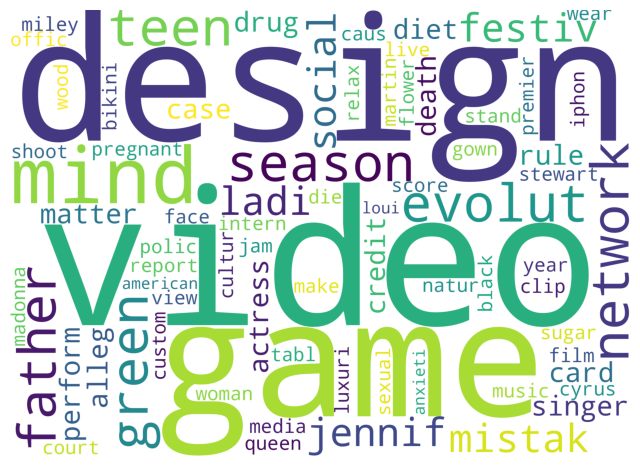


Wordcloud for topic: 1 



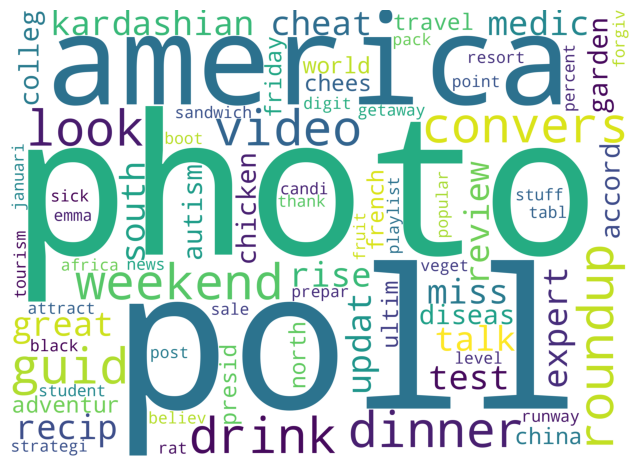


Wordcloud for topic: 2 



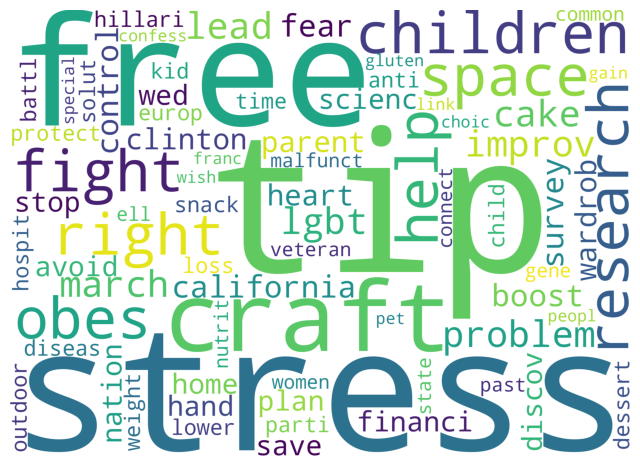


Wordcloud for topic: 3 



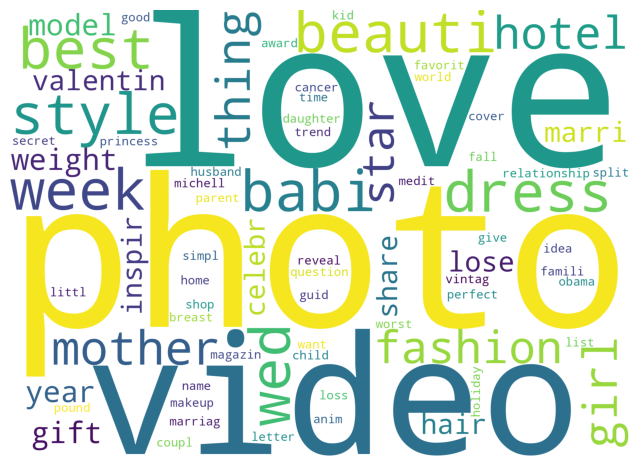


Wordcloud for topic: 4 



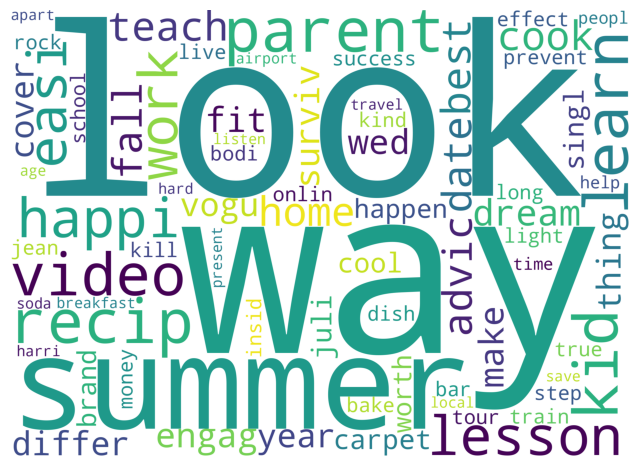


Wordcloud for topic: 5 



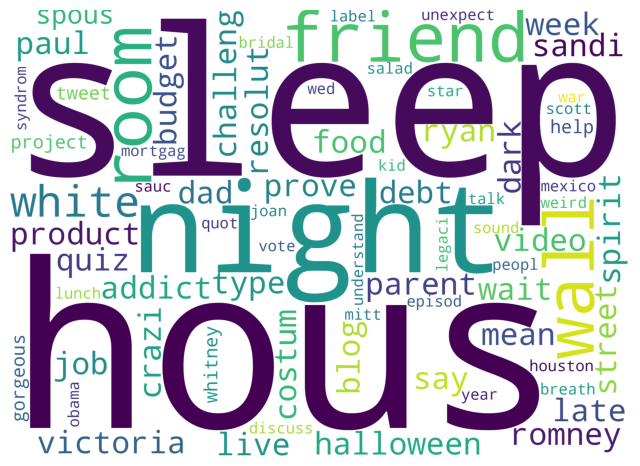


Wordcloud for topic: 6 



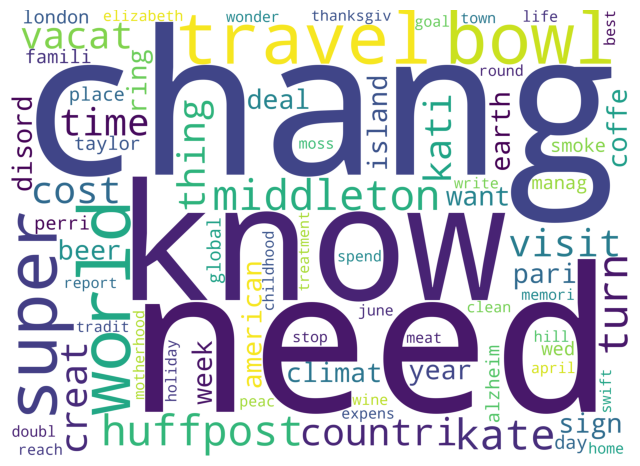


Wordcloud for topic: 7 



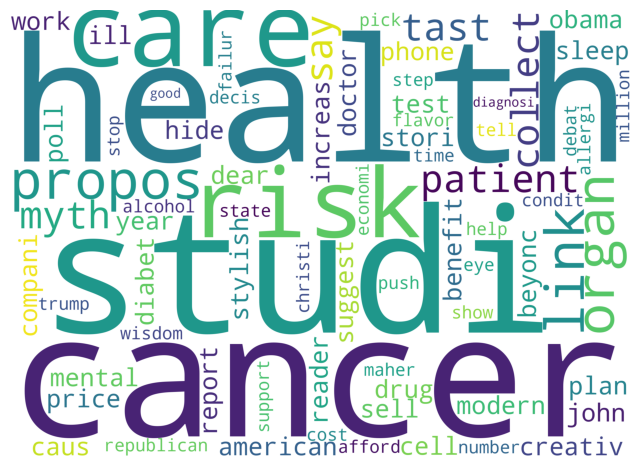


Wordcloud for topic: 8 



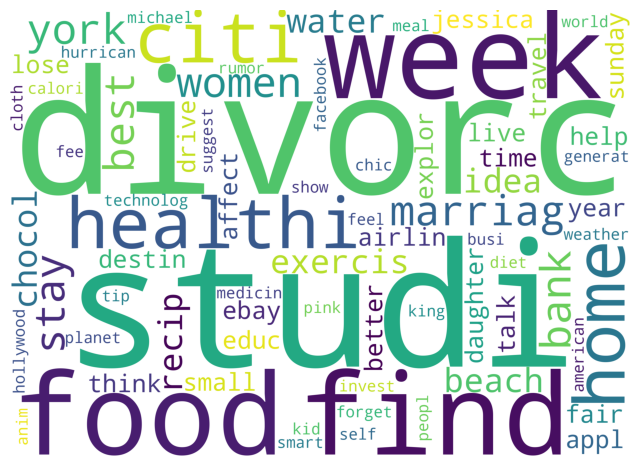


Wordcloud for topic: 9 



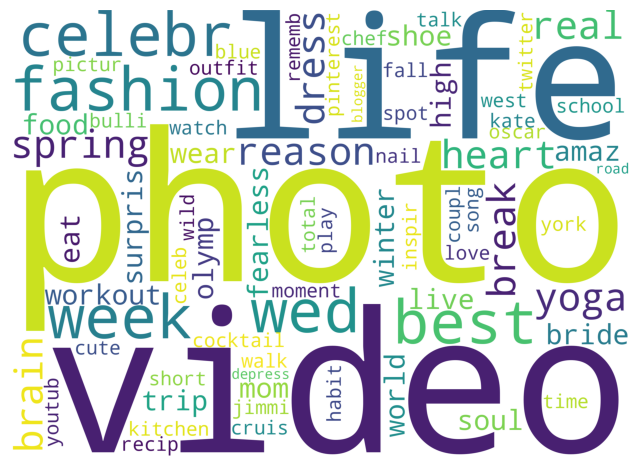

In [ ]:
for topic in range(10):
    #plt.figure(figsize=(10,15))
    word_cloud(topic, lda_model)